<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/Task2_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

# Download the model from Task 1 and datasets

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/1UmEHRAYuAhiqxZzi-oLxtstSE0YptOzf/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1UmEHRAYuAhiqxZzi-oLxtstSE0YptOzf
To: /content/resnet18_model_98.pth
100% 44.8M/44.8M [00:00<00:00, 70.7MB/s]


In [3]:
!gdown --fuzzy 'https://drive.google.com/file/d/1z5p-_SoJ-mYDsxvZH2i0PbYGwgHYrknz/view?usp=drive_link'
!gdown --fuzzy 'https://drive.google.com/file/d/1JQ9FaP6SBWlCB3ynxzmUTjDRAB9hc9mL/view?usp=drive_link'

# To test run on sample datasets 2 and 3, comment the lines above and run these instead:
# !gdown --fuzzy 'https://drive.google.com/file/d/1UlYZPCoX_rC1lJU8LG3rtYYn-cgzXOTb/view?usp=sharing'
# !gdown --fuzzy 'https://drive.google.com/file/d/1fJljKjN5unR16Qh7HeOsVF3jgYtwIQO-/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1z5p-_SoJ-mYDsxvZH2i0PbYGwgHYrknz
To: /content/Dataset_2.zip
100% 121M/121M [00:04<00:00, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JQ9FaP6SBWlCB3ynxzmUTjDRAB9hc9mL
To: /content/Dataset_3.zip
100% 275M/275M [00:02<00:00, 124MB/s]


In [4]:
!unzip 'Dataset_2.zip'
!unzip 'Dataset_3.zip'

# To continue test running on sample datasets 2 and 3, comment the lines above and run these instead:
# !unzip 'sampled_dataset2.zip'
# !unzip 'sampled_dataset3.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Animal Faces/cat/pixabay_cat_003744.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003745.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003746.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003747.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003749.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003750.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003751.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003752.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003754.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003756.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003757.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003758.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003759.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003760.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003761.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003762.jpg  
  inflating: Animal Faces/cat/pixabay_cat_003763.jpg  
  inflating: A

# Load pretrained model from Task 1

In [5]:
#This cell is for the user who are using pre-trained model. If you have run the training loop above and model is already trained, you can skip
pretrained_model = resnet18(weights=None)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.004083)

In [6]:
state_dict = torch.load('resnet18_model_98.pth')
pretrained_model.load_state_dict(state_dict)
# Remove the final classification layer to use the model as a feature extractor
pretrained_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-1]))

# Load a ResNet18 model with ImageNet weights

In [7]:
imagenet_model = resnet18(weights='IMAGENET1K_V1')
num_features = imagenet_model.fc.in_features
imagenet_model.fc = nn.Linear(num_features, 3)
# Remove the final classification layer to use the model as a feature extractor
imagenet_model = nn.Sequential(*(list(imagenet_model.children())[:-1]))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.6MB/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device);
imagenet_model.to(device);

# Prepare datasets

In [9]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
dataset2 = datasets.ImageFolder('Prostate Cancer', transform=transform)
dataset3 = datasets.ImageFolder('Animal Faces', transform=transform)

# To continue test running on sample datasets 2 and 3, comment the lines above and run these instead:
# dataset2 = datasets.ImageFolder('/content/sampled_dataset2/Prostate Cancer', transform=transform)
# dataset3 = datasets.ImageFolder('/content/sampled_dataset3/Animal Faces', transform=transform)

In [11]:
data_loader_2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)
data_loader_3 = torch.utils.data.DataLoader(dataset3, batch_size=64, shuffle=False)

# Extract Datasets 2 and 3 on Task 1 model and Imagenet model

In [12]:
def extract_features_and_labels(model, data_loader):
    model.eval()
    extracted_features = []
    y_tsne = []

    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Remove the last classification layer and extract features
            features = model(images)
            features = features.view(features.size(0), -1)

            extracted_features.append(features.cpu().detach().numpy())
            y_tsne.append(labels.cpu().detach().numpy())  # Assuming the labels are not already on the CPU

    # Concatenate all features and labels to get the full set
    extracted_features = np.concatenate(extracted_features, axis=0)
    y_tsne = np.concatenate(y_tsne, axis=0)

    return extracted_features, y_tsne

In [13]:
dataset2_features_task1, dataset2_labels_task1 = extract_features_and_labels(pretrained_model, data_loader_2)
dataset3_features_task1, dataset3_labels_task1 = extract_features_and_labels(pretrained_model, data_loader_3)

In [14]:
dataset2_features_inet, dataset2_labels_inet = extract_features_and_labels(imagenet_model, data_loader_2)
dataset3_features_inet, dataset3_labels_inet = extract_features_and_labels(imagenet_model, data_loader_3)

# Visualize the new sets with t-SNE

In [15]:
from sklearn.manifold import TSNE

def tsne_visualization_with_labels(features, labels, title):
    # Apply t-SNE to reduce the features to 2D
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    # Plotting with color-coding for labels
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Select indices of data points with the current label
        indices = labels == label
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=label, alpha=0.5)

    plt.title(f't-SNE Visualization of {title}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Labels')
    plt.show()

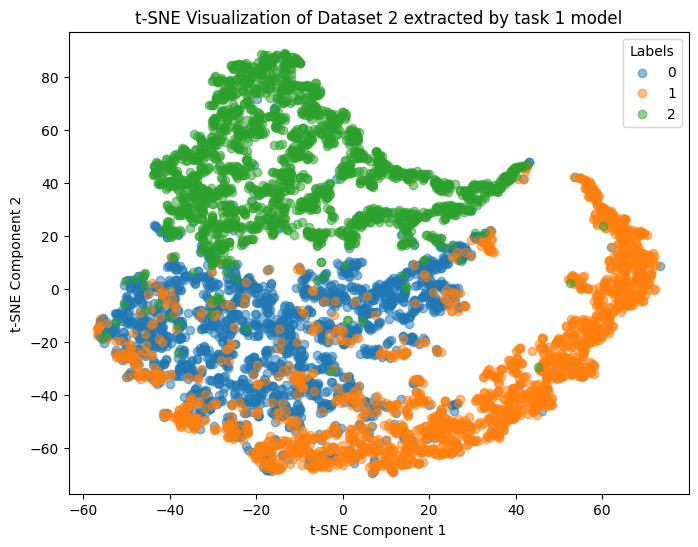

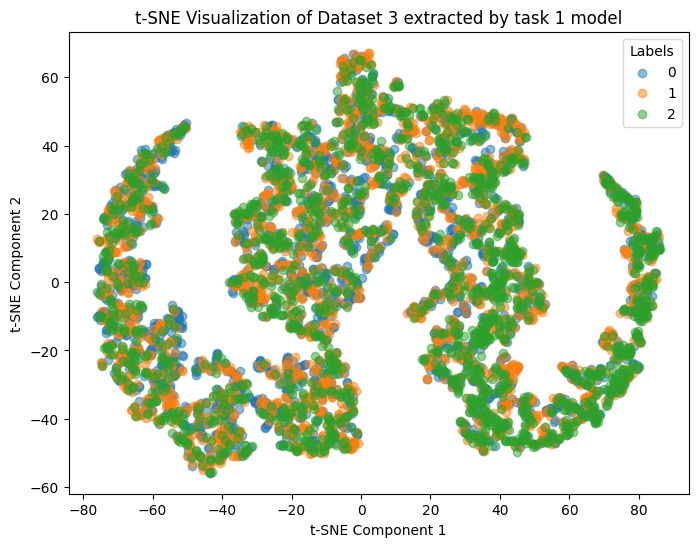

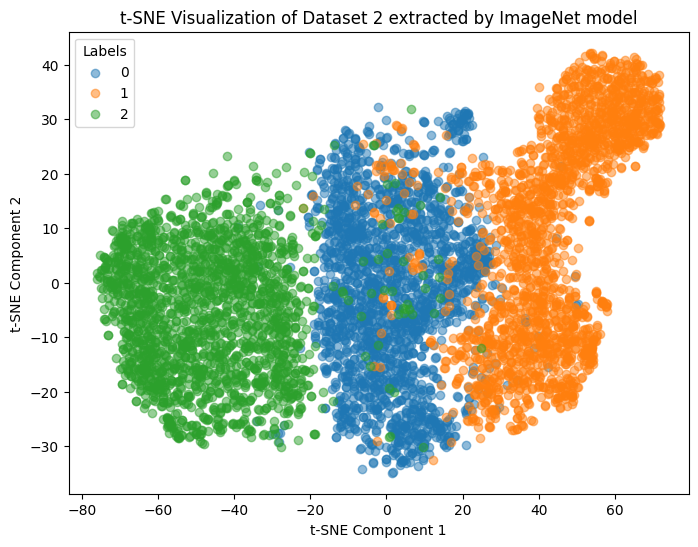

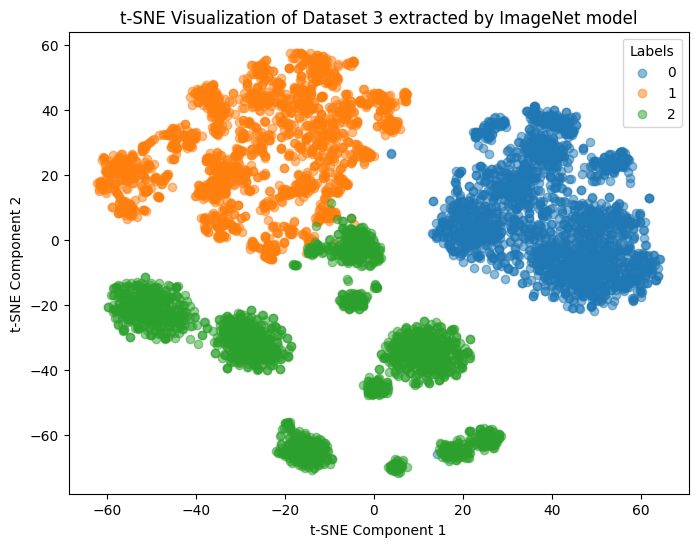

In [16]:
tsne_visualization_with_labels(dataset2_features_task1, dataset2_labels_task1, "Dataset 2 extracted by task 1 model")
tsne_visualization_with_labels(dataset3_features_task1, dataset3_labels_task1, "Dataset 3 extracted by task 1 model")
tsne_visualization_with_labels(dataset2_features_inet, dataset2_labels_inet, "Dataset 2 extracted by ImageNet model" )
tsne_visualization_with_labels(dataset3_features_inet, dataset3_labels_inet, "Dataset 3 extracted by ImageNet model")

# Save dataset to csv file

In [ ]:
def save_dataset_to_csv(features, labels, title):
    df = pd.DataFrame(features)
    df['label'] = labels  # Add labels as a new column

    # Save to CSV
    df.to_csv(f'{title}.csv', index=False)

In [ ]:
save_dataset_to_csv(dataset2_features_task1, dataset2_labels_task1, "Dataset2_task1model")
save_dataset_to_csv(dataset3_features_task1, dataset3_labels_task1, "Dataset3_task1model")

In [ ]:
save_dataset_to_csv(dataset2_features_inet, dataset2_labels_inet, "Dataset2_imagenet")
save_dataset_to_csv(dataset3_features_inet, dataset3_labels_inet, "Dataset3_imagenet")